In [74]:
# Prepare for data analysis
# Load packages
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

In [75]:
%%time
train_df_all = pd.read_csv("train.csv")

CPU times: user 12.1 s, sys: 978 ms, total: 13.1 s
Wall time: 13.8 s


In [76]:
# split train dataset as train and validation dataset
train_df = train_df_all[:160000]
val_df = train_df_all[160000:]

In [10]:
train_df.shape, val_df.shape

((160000, 202), (40000, 202))

In [11]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [12]:
val_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
160000,train_160000,0,12.2320,-9.1125,8.7408,5.2574,11.2683,6.8585,4.3081,20.9530,...,8.7776,13.9707,5.7758,5.4848,23.7953,-1.0828,-2.9849,8.0768,17.2265,-12.4161
160001,train_160001,0,13.1005,-3.5548,12.2100,9.4847,11.6753,-0.1341,6.4490,17.4421,...,-0.0859,9.1992,3.2505,6.6660,16.2758,-2.4799,5.7432,9.7810,20.3229,-12.4004
160002,train_160002,0,9.2485,-2.2238,13.2795,8.1007,12.2664,-12.2029,6.3607,12.3053,...,0.2219,9.0083,2.2405,8.5621,19.4612,-0.7591,14.0509,9.6169,19.3157,-0.5091
160003,train_160003,0,9.6670,-0.1424,9.0655,6.6891,13.6792,-13.4911,4.2528,11.3340,...,1.3145,7.0578,2.8789,-1.3968,18.1007,1.1577,11.4426,7.5163,7.3102,-18.5475
160004,train_160004,1,9.0380,-3.5932,9.7009,7.3518,11.3797,1.4633,4.7521,11.7099,...,6.2602,10.4499,2.8112,2.4556,22.0856,1.5892,1.3600,8.6511,19.3737,-6.5622


In [13]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [14]:
%%time
missing_data(train_df)

CPU times: user 2.43 s, sys: 193 ms, total: 2.62 s
Wall time: 2.22 s


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [15]:
%%time
missing_data(val_df)

CPU times: user 940 ms, sys: 52.5 ms, total: 992 ms
Wall time: 521 ms


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [16]:
%%time
train_df.describe()

CPU times: user 2.92 s, sys: 170 ms, total: 3.09 s
Wall time: 3.15 s


,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,...,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000
mean,0.100306,10.675970,-1.631668,10.713082,6.794993,11.079086,-5.075568,5.407938,16.558434,0.281299,...,3.224485,7.437849,1.927598,3.334776,17.996864,-0.142914,2.287905,8.911568,15.871196,-3.330810
std,0.300409,3.039976,4.051973,2.638770,2.043842,1.622609,7.848528,0.866158,3.415767,3.332977,...,4.559465,3.020735,1.476612,3.993537,3.135678,1.427727,5.454749,0.921926,3.010696,10.447450
min,0.000000,0.452800,-15.043400,2.117100,-0.040200,5.277800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.020400,5.960600,6.299300,-38.852800
25%,0.000000,8.451700,-4.750150,8.721600,5.250600,9.884400,-11.198500,4.768500,13.956875,-2.319800,...,-0.069700,5.158500,0.892000,0.583575,15.633075,-1.166600,-1.972825,8.254900,13.832200,-11.243925
50%,0.000000,10.523750,-1.614800,10.578400,6.822450,11.109700,-4.835600,5.385500,16.474050,0.384450,...,3.190900,7.349900,1.901400,3.396300,17.960600,-0.174400,2.386700,8.892000,15.936400,-2.819800
75%,0.000000,12.751200,1.361100,12.511925,8.324600,12.261225,0.893850,6.001600,19.112025,2.936900,...,6.401000,9.507225,2.947300,6.213400,20.401325,0.825500,6.543825,9.596600,18.064950,4.846625
max,1.000000,20.315000,10.335600,18.652100,13.188300,16.671400,17.251600,8.447700,27.638900,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,27.534000


In [17]:
%time
val_df.describe()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 12.2 µs


,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,...,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,0.101225,10.695690,-1.611435,10.723630,6.802673,11.075323,-5.024317,5.412990,16.495513,0.295612,...,3.274261,7.440647,1.928799,3.319765,17.981463,-0.138788,2.365057,8.894517,15.868817,-3.309446
std,0.301630,3.040335,4.042330,2.649388,2.041240,1.625325,7.921913,0.868400,3.426874,3.331278,...,4.561587,3.033434,1.485664,3.986026,3.133104,1.435948,5.452480,0.920308,3.011981,10.400302
min,0.000000,0.408400,-14.091000,2.313400,0.374000,5.074800,-29.777300,2.587500,6.465300,-10.265300,...,-13.454700,-1.918900,-3.349500,-9.873200,9.445400,-4.845700,-14.209600,6.160400,7.108000,-37.223000
25%,0.000000,8.464700,-4.697550,8.726875,5.269775,9.877600,-11.210875,4.764475,13.884350,-2.310875,...,-0.012150,5.153800,0.878400,0.592675,15.617100,-1.185600,-1.838925,8.243375,13.819050,-11.067300
50%,0.000000,10.527700,-1.582500,10.588050,6.833450,11.102700,-4.822800,5.383700,16.396950,0.433850,...,3.256750,7.337900,1.900900,3.396600,17.946200,-0.163650,2.504250,8.870800,15.926000,-2.818150
75%,0.000000,12.788025,1.351250,12.536100,8.320450,12.260950,1.057125,6.007400,19.062650,2.942425,...,6.431700,9.532550,2.957200,6.168775,20.370800,0.842800,6.606625,9.582250,18.063775,4.800200
max,1.000000,19.998400,10.376800,19.353000,12.870600,15.991400,16.806500,8.037900,27.691800,9.605300,...,17.342600,16.349200,7.679100,17.908600,27.293100,4.082900,17.684100,11.887600,26.034600,28.500700


In [36]:
# show 5% data, x axis:train values,y axis:test values.
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,10,figsize=(20,5))

    for feature in features:
        i += 1
        plt.subplot(2,10,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show();

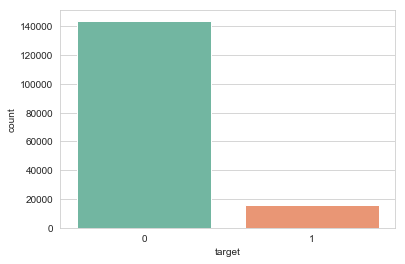

In [20]:
sns.countplot(train_df['target'], palette='Set2')

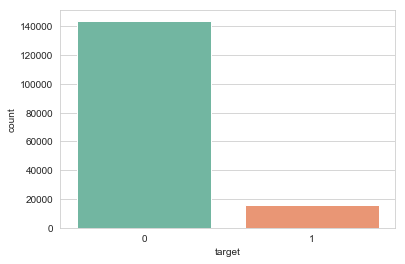

In [21]:
sns.countplot(train_df['target'], palette='Set2')

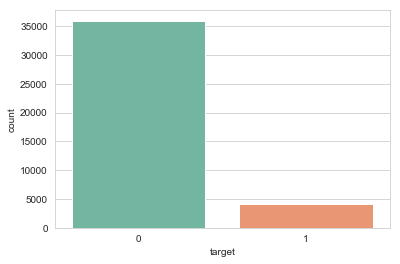

In [22]:
sns.countplot(val_df['target'], palette='Set2')

In [24]:
print("All dataset {}% target 1s".format(100 * train_df_all["target"].value_counts()[1]/train_df_all.shape[0]))
print("Train set {}% target 1s".format(100 * train_df["target"].value_counts()[1]/train_df.shape[0]))
print("Val set {}% target 1s".format(100 * val_df["target"].value_counts()[1]/val_df.shape[0]))

All dataset 10.049% target 1s
Train set 10.030625% target 1s
Val set 10.1225% target 1s


In [44]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,5,figsize=(20,16))

    for feature in features:
        i += 1
        plt.subplot(4,5,i)
        sns.distplot(df1[feature], hist=False,label=label1, color="red")
        sns.distplot(df2[feature], hist=False,label=label2, color="blue")
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

<Figure size 432x288 with 0 Axes>

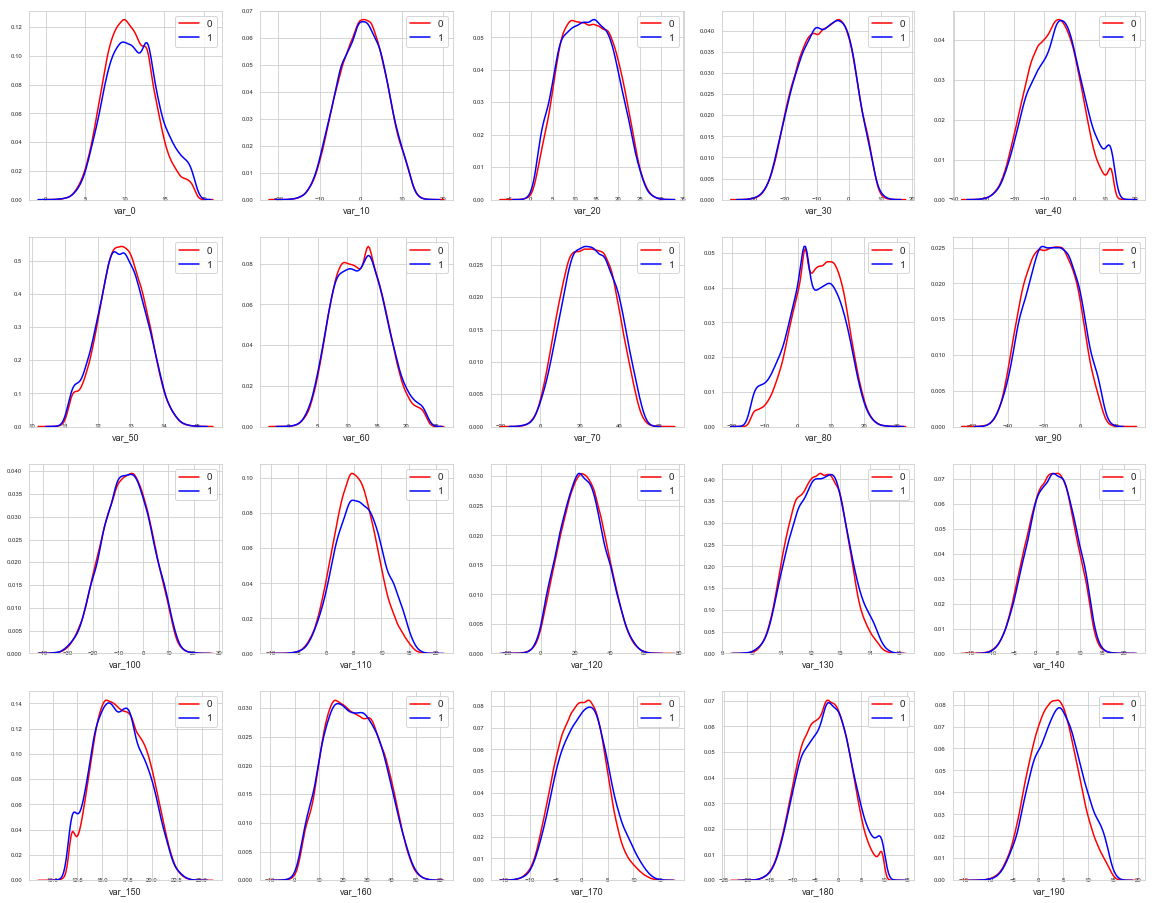

In [45]:
t0 = train_df_all.loc[train_df_all['target'] == 0]
t1 = train_df_all.loc[train_df_all['target'] == 1]
# sample 20 attributes to show
features = train_df.columns.values[2:202:10]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

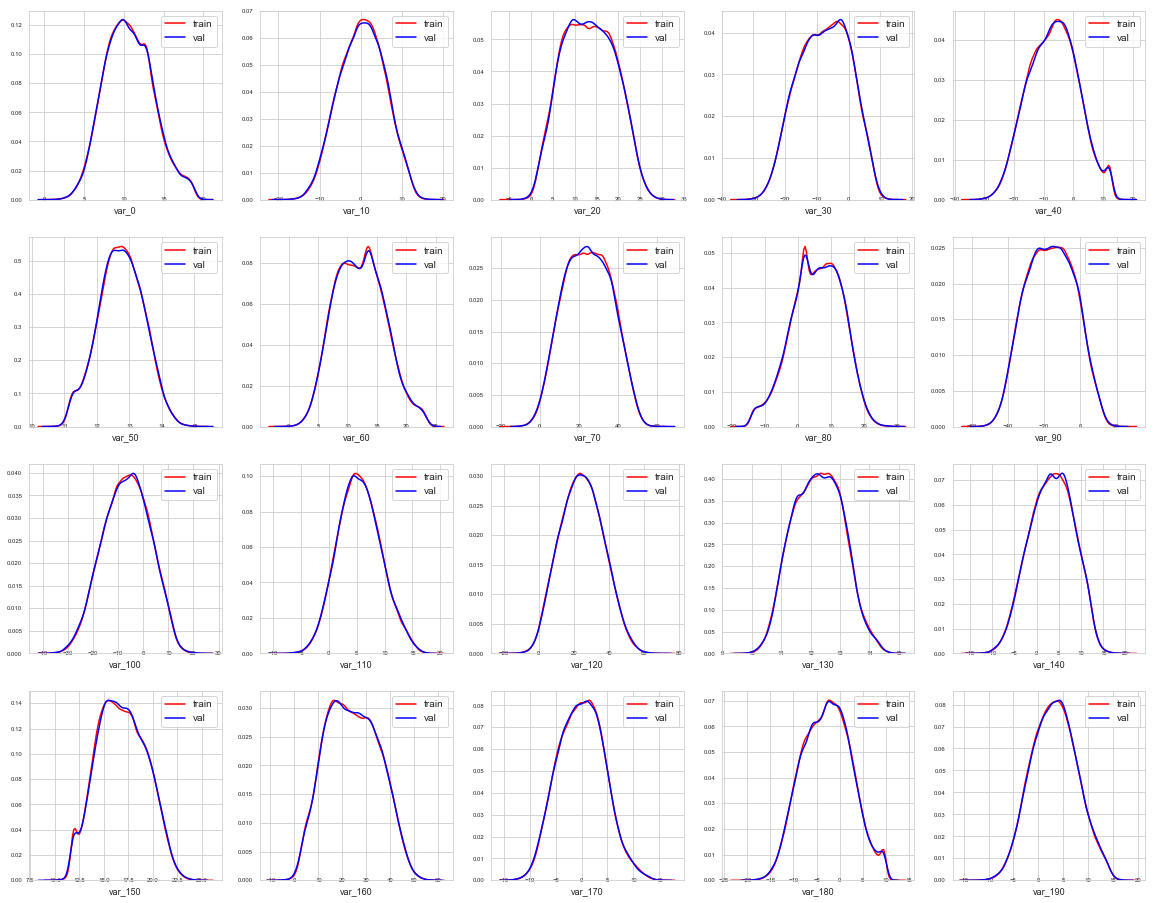

In [46]:
features = train_df.columns.values[2:202:10]
plot_feature_distribution(train_df, val_df, 'train', 'val', features)

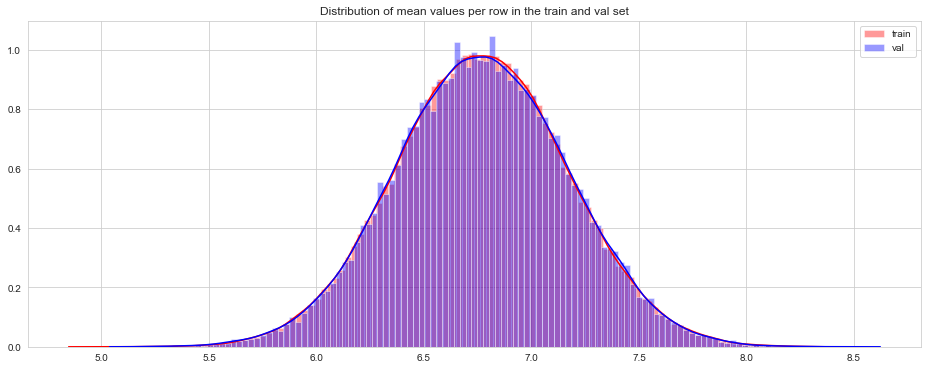

In [62]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of mean values per row in the train and val set")
sns.distplot(train_df[features].mean(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(val_df[features].mean(axis=1),color="blue", kde=True,bins=120, label='val')
plt.legend()
plt.show()

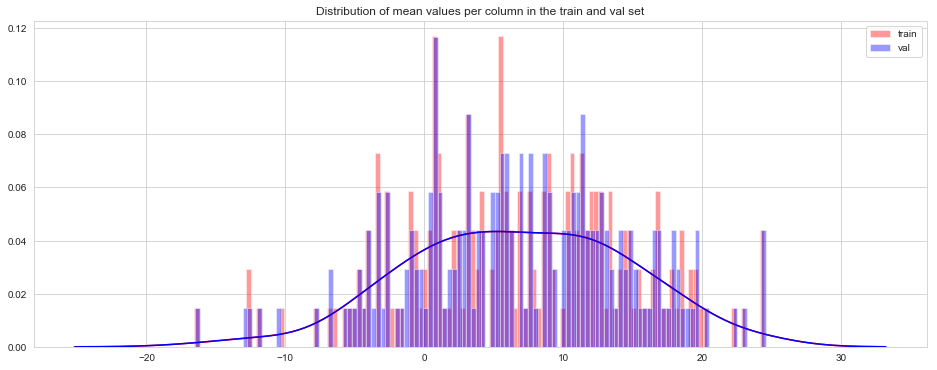

In [61]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and val set")
sns.distplot(train_df[features].mean(axis=0),color="red",kde=True,bins=120, label='train')
sns.distplot(val_df[features].mean(axis=0),color="blue", kde=True,bins=120, label='val')
plt.legend()
plt.show()

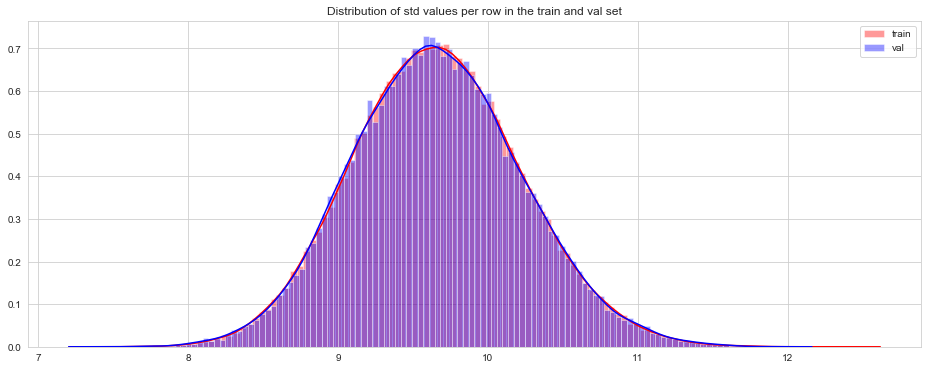

In [60]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and val set")
sns.distplot(train_df[features].std(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(val_df[features].std(axis=1),color="blue", kde=True,bins=120, label='val')
plt.legend();plt.show()

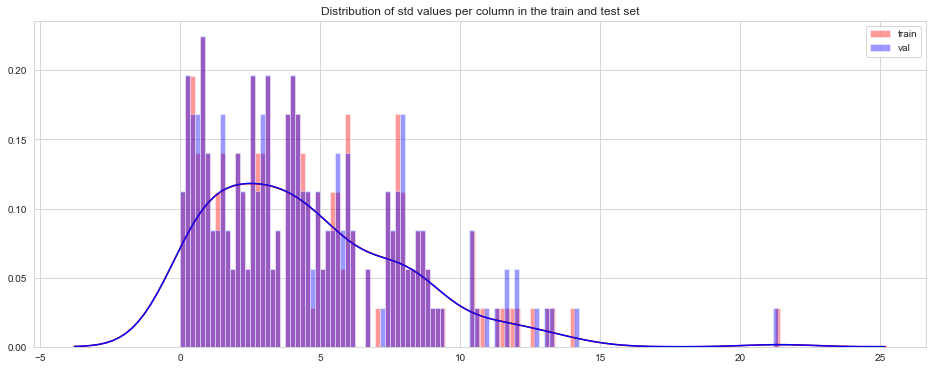

In [50]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train_df[features].std(axis=0),color="red",kde=True,bins=120, label='train')
sns.distplot(val_df[features].std(axis=0),color="blue", kde=True,bins=120, label='val')
plt.legend(); plt.show()

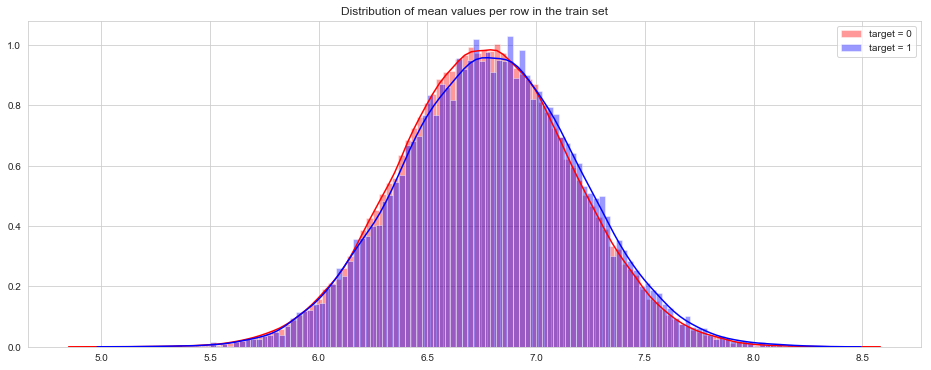

In [24]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

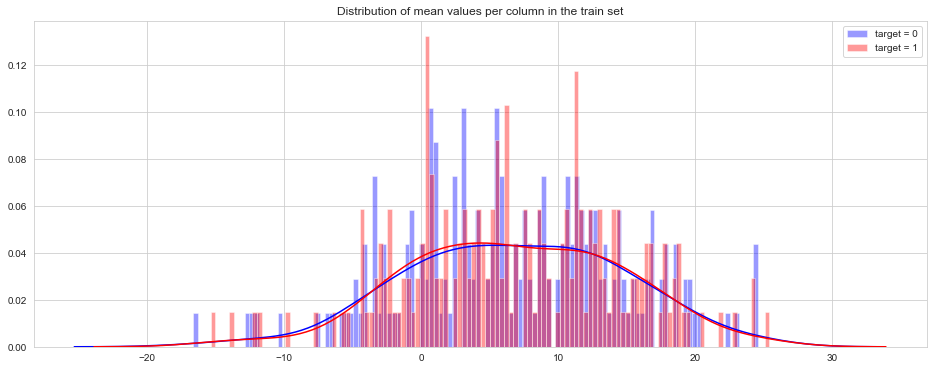

In [51]:
#Let's check now the distribution of the mean value per column in the train dataset, grouped by value of target.
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[features].mean(axis=0),color="blue", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="red", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

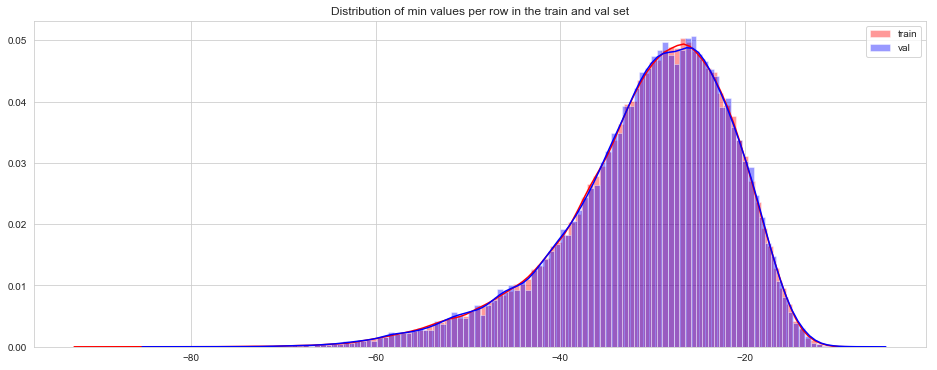

In [63]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of min values per row in the train and val set")
sns.distplot(train_df[features].min(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(val_df[features].min(axis=1),color="blue", kde=True,bins=120, label='val')
plt.legend()
plt.show()

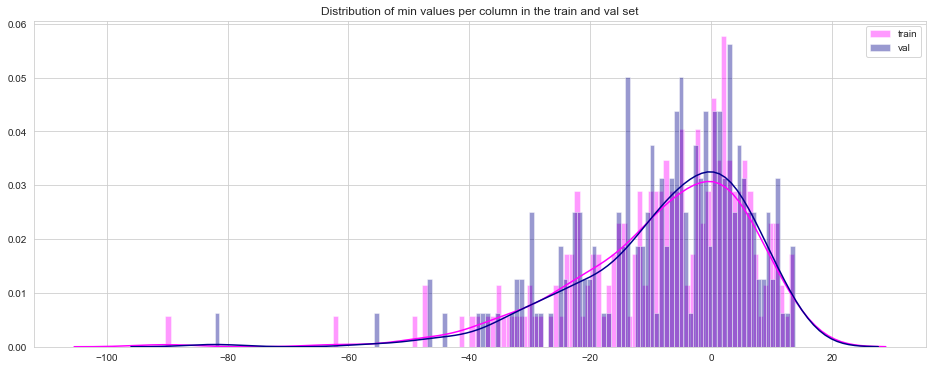

In [64]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of min values per column in the train and val set")
sns.distplot(train_df[features].min(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(val_df[features].min(axis=0),color="darkblue", kde=True,bins=120, label='val')
plt.legend()
plt.show()

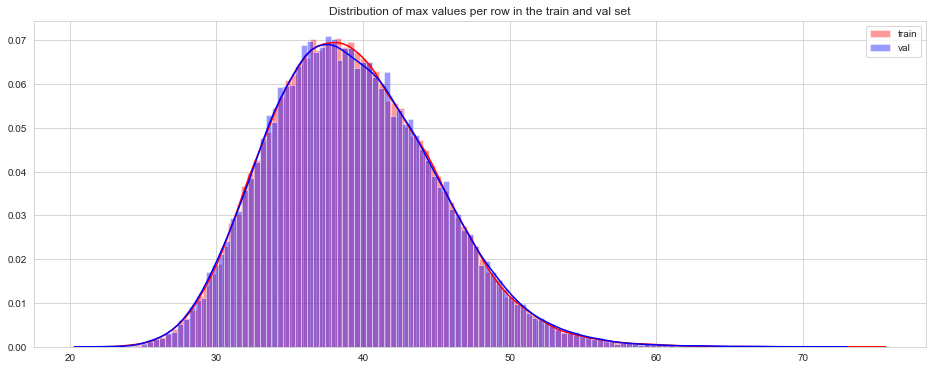

In [65]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of max values per row in the train and val set")
sns.distplot(train_df[features].max(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(val_df[features].max(axis=1),color="blue", kde=True,bins=120, label='val')
plt.legend()
plt.show()

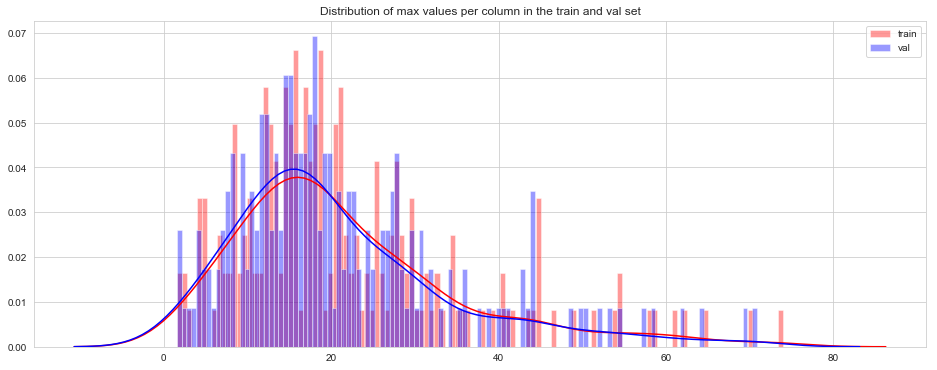

In [66]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of max values per column in the train and val set")
sns.distplot(train_df[features].max(axis=0),color="red", kde=True,bins=120, label='train')
sns.distplot(val_df[features].max(axis=0),color="blue", kde=True,bins=120, label='val')
plt.legend()
plt.show()

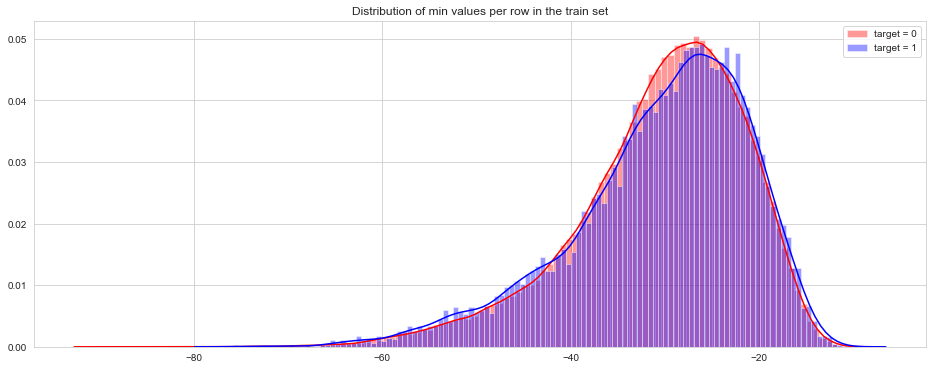

In [55]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per row in the train set")
sns.distplot(t0[features].min(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

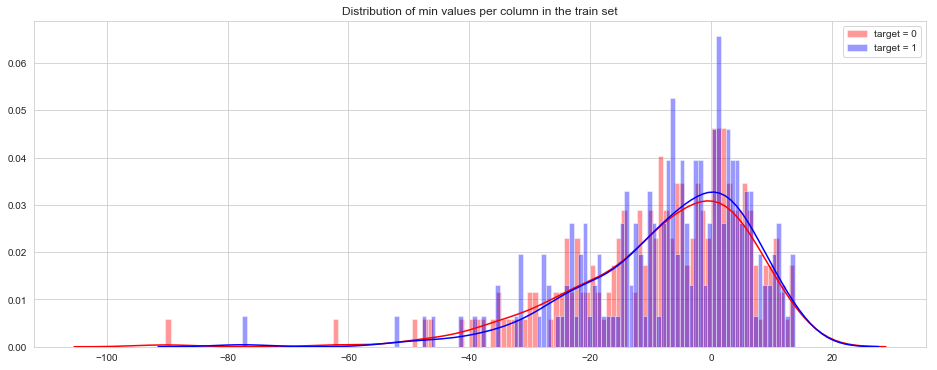

In [31]:
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per column in the train set")
sns.distplot(t0[features].min(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

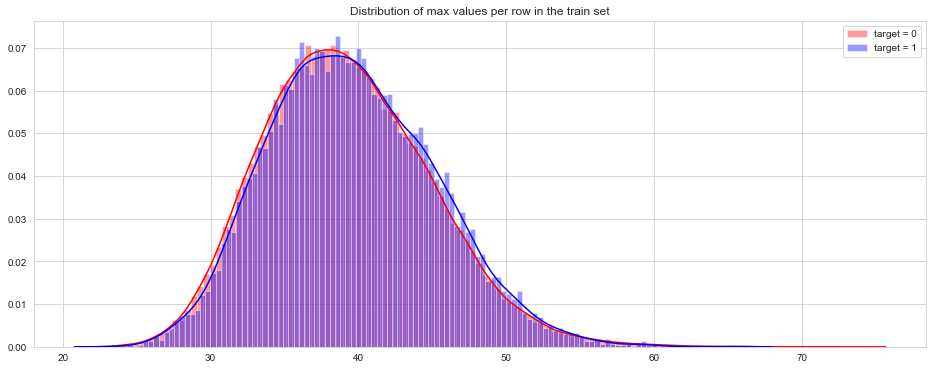

In [56]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per row in the train set")
sns.distplot(t0[features].max(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

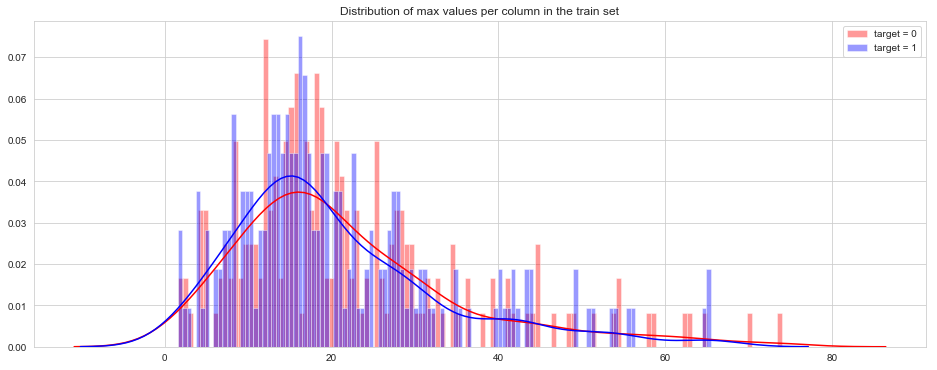

In [33]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per column in the train set")
sns.distplot(t0[features].max(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

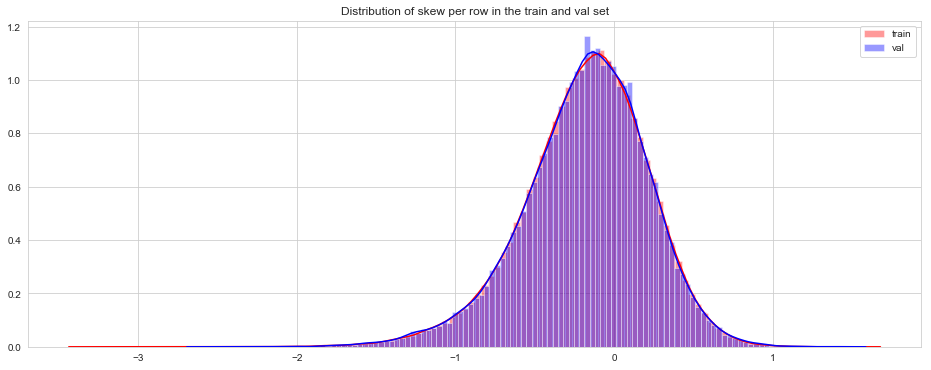

In [67]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per row in the train and val set")
sns.distplot(train_df[features].skew(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(val_df[features].skew(axis=1),color="blue", kde=True,bins=120, label='val')
plt.legend()
plt.show()

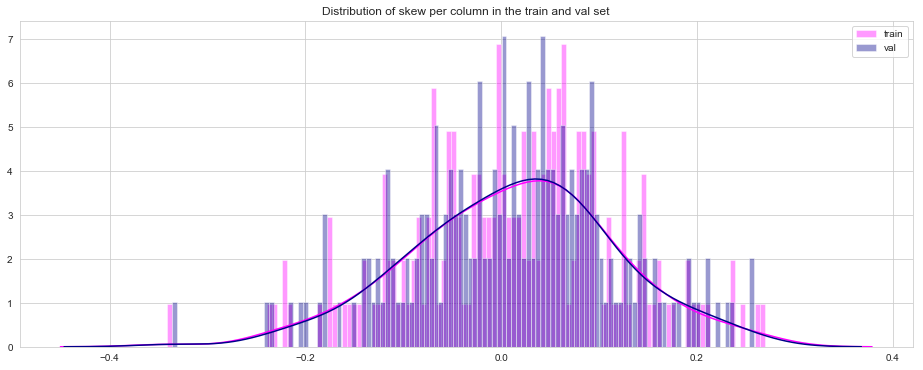

In [68]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per column in the train and val set")
sns.distplot(train_df[features].skew(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(val_df[features].skew(axis=0),color="darkblue", kde=True,bins=120, label='val')
plt.legend()
plt.show()

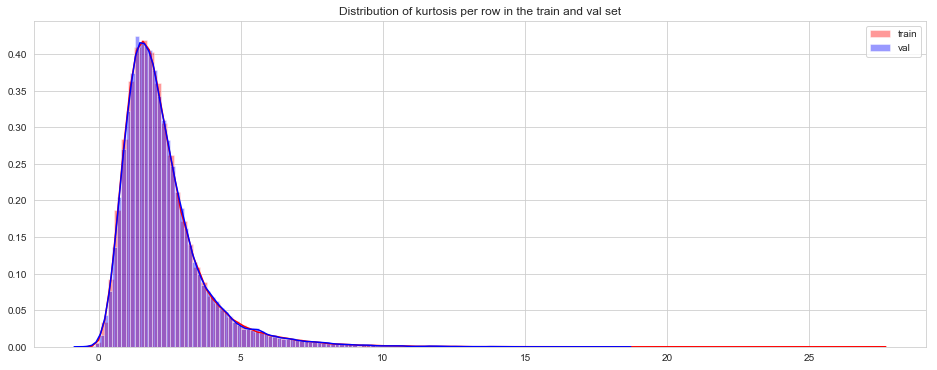

In [69]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per row in the train and val set")
sns.distplot(train_df[features].kurtosis(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(val_df[features].kurtosis(axis=1),color="blue", kde=True,bins=120, label='val')
plt.legend()
plt.show()

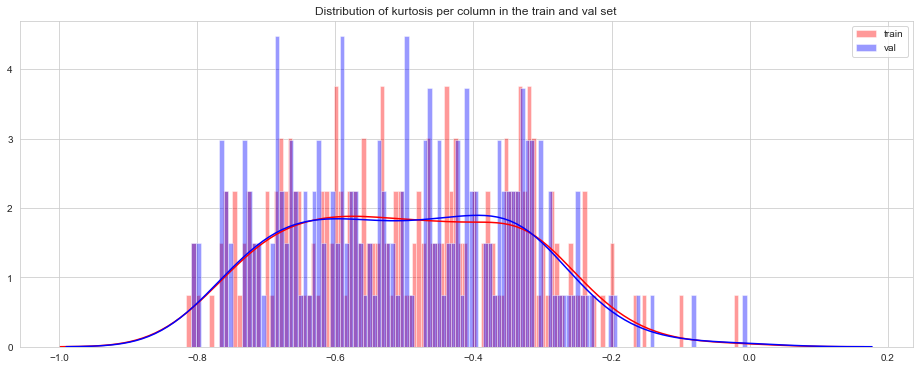

In [70]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per column in the train and val set")
sns.distplot(train_df[features].kurtosis(axis=0),color="red", kde=True,bins=120, label='train')
sns.distplot(val_df[features].kurtosis(axis=0),color="blue", kde=True,bins=120, label='val')
plt.legend()
plt.show()

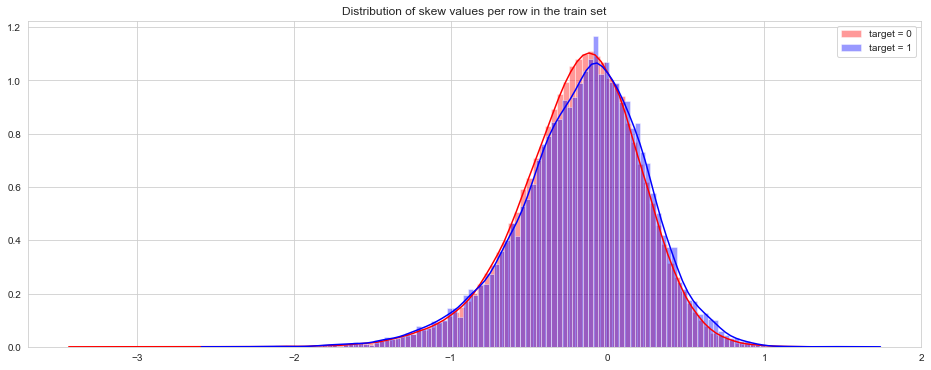

In [38]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per row in the train set")
sns.distplot(t0[features].skew(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

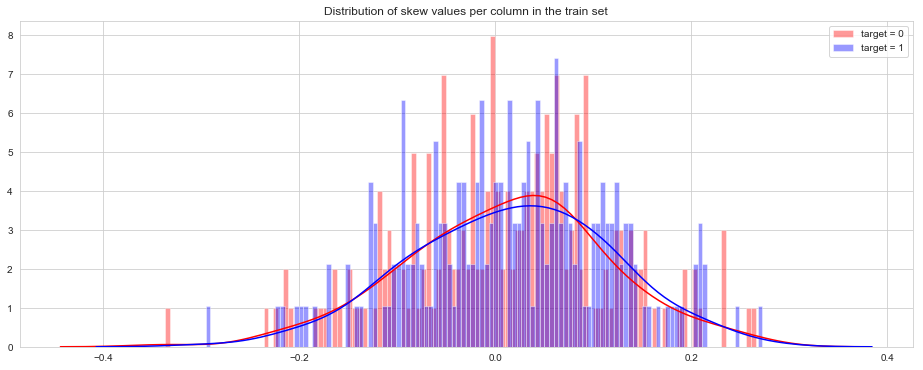

In [39]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per column in the train set")
sns.distplot(t0[features].skew(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

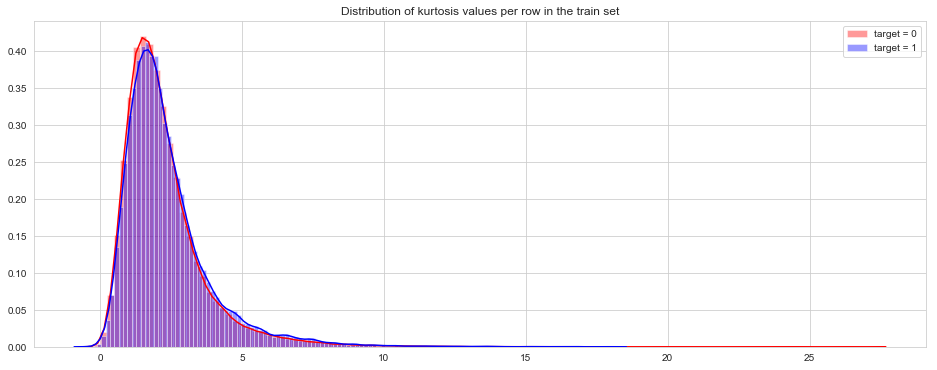

In [40]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per row in the train set")
sns.distplot(t0[features].kurtosis(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

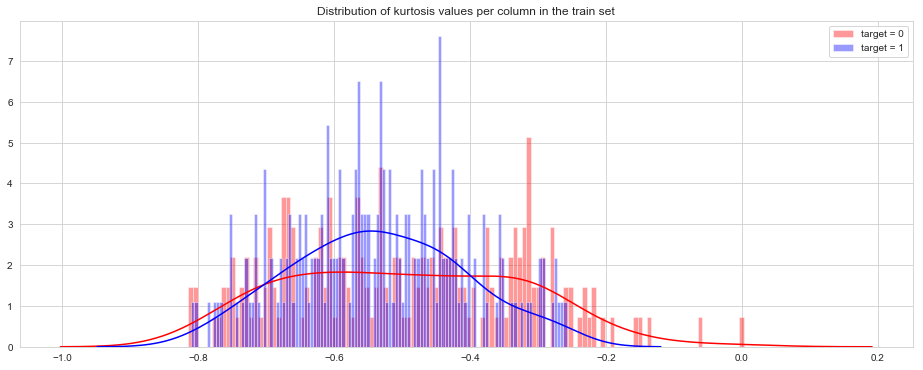

In [41]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per column in the train set")
sns.distplot(t0[features].kurtosis(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

In [42]:
%%time
correlations = train_df[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)

CPU times: user 18.3 s, sys: 332 ms, total: 18.6 s
Wall time: 20.5 s


In [43]:
correlations.tail(10)

,level_0,level_1,0
39790,var_183,var_189,0.009359
39791,var_189,var_183,0.009359
39792,var_174,var_81,0.009490
39793,var_81,var_174,0.009490
39794,var_81,var_165,0.009714
39795,var_165,var_81,0.009714
39796,var_53,var_148,0.009788
39797,var_148,var_53,0.009788
39798,var_26,var_139,0.009844
39799,var_139,var_26,0.009844


In [44]:
correlations.head(10)

,level_0,level_1,0
0,var_75,var_191,2.703975e-08
1,var_191,var_75,2.703975e-08
2,var_173,var_6,5.942735e-08
3,var_6,var_173,5.942735e-08
4,var_126,var_109,1.313947e-07
5,var_109,var_126,1.313947e-07
6,var_144,var_27,1.772502e-07
7,var_27,var_144,1.772502e-07
8,var_177,var_100,3.116544e-07
9,var_100,var_177,3.116544e-07


In [45]:
%%time
features = train_df.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train_df[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = test_df[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

CPU times: user 7.67 s, sys: 1.04 s, total: 8.71 s
Wall time: 8.74 s


In [46]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,108,126,12,91,103,148,71,161,25,125,169,166,133,43
Feature,var_68,var_108,var_126,var_12,var_91,var_103,var_148,var_71,var_161,var_25,var_125,var_169,var_166,var_133,var_43
Max duplicates,1084,313,305,203,66,61,59,54,52,41,40,39,39,39,39
Value,5.0214,14.1999,11.5356,13.5545,6.9785,1.6662,4.0456,0.7031,5.7688,13.6723,12.5159,5.6941,2.7306,6.8632,11.4522


In [47]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,126,108,12,91,103,148,161,25,71,43,166,125,169,133
Feature,var_68,var_126,var_108,var_12,var_91,var_103,var_148,var_161,var_25,var_71,var_43,var_166,var_125,var_169,var_133
Max duplicates,1104,307,302,188,86,78,74,69,60,60,58,53,53,51,50
Value,5.0197,11.5357,14.1999,13.5546,6.9939,1.4659,4.0004,5.7114,13.5965,0.5389,11.5738,2.8446,12.2189,5.8455,6.6873


In [48]:
%%time
idx = features = train_df.columns.values[2:202]
for df in [test_df, train_df]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

CPU times: user 15.8 s, sys: 12.2 s, total: 28.1 s
Wall time: 26.7 s


In [49]:
train_df[train_df.columns[202:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,1456.3182,-21.4494,43.1127,7.281591,9.331540,0.101580,1.331023,6.77040
1,1415.3636,-47.3797,40.5632,7.076818,10.336130,-0.351734,4.110215,7.22315
2,1240.8966,-22.4038,33.8820,6.204483,8.753387,-0.056957,0.546438,5.89940
3,1288.2319,-35.1659,38.1015,6.441159,9.594064,-0.480116,2.630499,6.70260
4,1354.2310,-65.4863,41.1037,6.771155,11.287122,-1.463426,9.787399,6.94735


In [50]:
test_df[test_df.columns[201:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,1416.6404,-31.9891,42.0248,7.083202,9.910632,-0.088518,1.871262,7.31440
1,1249.6860,-41.1924,35.6020,6.248430,9.541267,-0.559785,3.391068,6.43960
2,1430.2599,-34.3488,39.3654,7.151299,9.967466,-0.135084,2.326901,7.26355
3,1411.4447,-21.4797,40.3383,7.057223,8.257204,-0.167741,2.253054,6.89675
4,1423.7364,-24.8254,45.5510,7.118682,10.043542,0.293484,2.044943,6.83375


In [51]:
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

<Figure size 432x288 with 0 Axes>

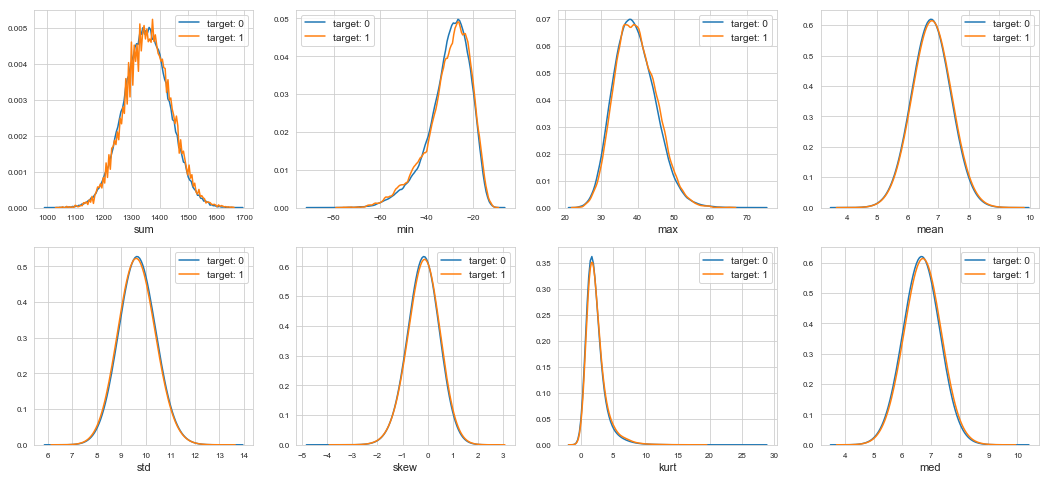

In [52]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[202:]
plot_new_feature_distribution(t0, t1, 'target: 0', 'target: 1', features)

<Figure size 432x288 with 0 Axes>

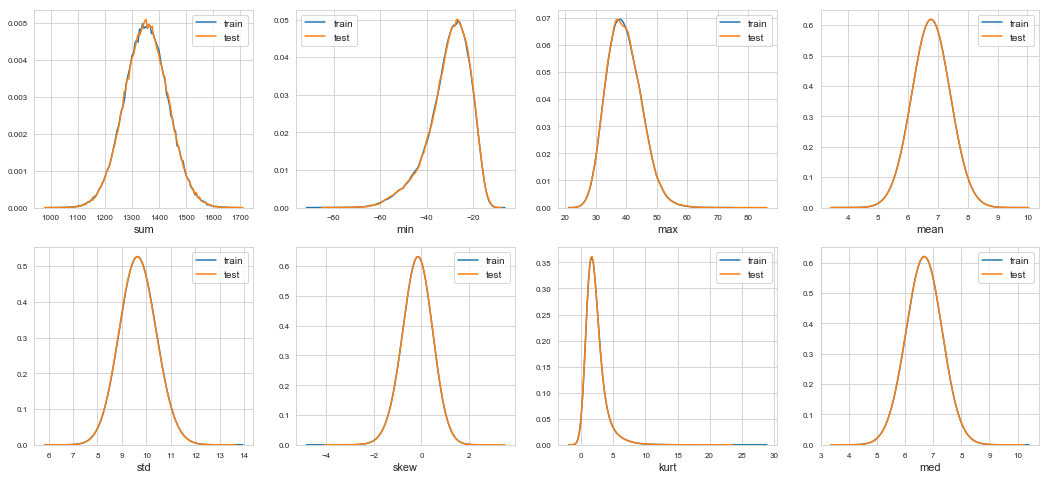

In [53]:
features = train_df.columns.values[202:]
plot_new_feature_distribution(train_df, test_df, 'train', 'test', features)

In [54]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
for feature in features:
    train_df['r2_'+feature] = np.round(train_df[feature], 2)
    test_df['r2_'+feature] = np.round(test_df[feature], 2)
    train_df['r1_'+feature] = np.round(train_df[feature], 1)
    test_df['r1_'+feature] = np.round(test_df[feature], 1)

In [55]:
print('Train and test columns: {} {}'.format(len(train_df.columns), len(test_df.columns)))

Train and test columns: 626 625


In [56]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']

In [57]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [59]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.884593	valid_1's auc: 0.864302
[2000]	training's auc: 0.909577	valid_1's auc: 0.884306
[3000]	training's auc: 0.921215	valid_1's auc: 0.892392
[4000]	training's auc: 0.928585	valid_1's auc: 0.896331
[5000]	training's auc: 0.934231	valid_1's auc: 0.898241
[6000]	training's auc: 0.939131	valid_1's auc: 0.899085
[7000]	training's auc: 0.943649	valid_1's auc: 0.89976
[8000]	training's auc: 0.947883	valid_1's auc: 0.899938
[9000]	training's auc: 0.951994	valid_1's auc: 0.900004
[10000]	training's auc: 0.95586	valid_1's auc: 0.900046
[11000]	training's auc: 0.959487	valid_1's auc: 0.899967
Early stopping, best iteration is:
[8822]	training's auc: 0.951261	valid_1's auc: 0.900092
Fold 1
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.885063	valid_1's auc: 0.865174
[2000]	training's auc: 0.909539	valid_1's auc: 0.884678
[3000]	training's auc: 0.921045	valid_1